In [21]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
from tqdm import tqdm#_notebook as tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
import os
from scipy.optimize import minimize
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision import transforms, utils

PATH = 'D:/Dataset_DL/'

## Reading Dataset

In [22]:
train = pd.read_csv(PATH + 'train.csv')
test = pd.read_csv(PATH + 'sample_submission.csv')
train.head()

ImageId                                   PredictionString
0  ID_8a6e65317  16 0.254839 -2.57534 -3.10256 7.96539 3.20066 ...
1  ID_337ddc495  66 0.163988 0.192169 -3.12112 -3.17424 6.55331...
2  ID_a381bf4d0  43 0.162877 0.00519276 -3.02676 2.1876 3.53427...
3  ID_7c4a3e0aa  43 0.126957 -3.04442 -3.10883 -14.738 24.6389 ...
4  ID_8b510fad6  37 0.16017 0.00862796 -3.0887 -3.04548 3.4977 ...

In [23]:
train = pd.read_csv(PATH + 'train.csv')
test = pd.read_csv(PATH + 'sample_submission.csv')
train.tail()

ImageId                                   PredictionString
4257  ID_de17ab626  70 0.177583 -0.023215 -3.08003 -25.3682 7.5732...
4258  ID_5a669e211  12 0.23817 -3.12745 3.13929 -7.21988 3.09626 1...
4259  ID_aa6ffba0a  35 0.166437 -0.497963 -3.12063 12.6792 5.48256...
4260  ID_29454123f  70 0.14292 0.0290822 -3.12594 -3.42749 3.38674...
4261  ID_2dee4d6e6  35 0.166939 3.08081 -3.11637 -14.8892 6.55844 ...

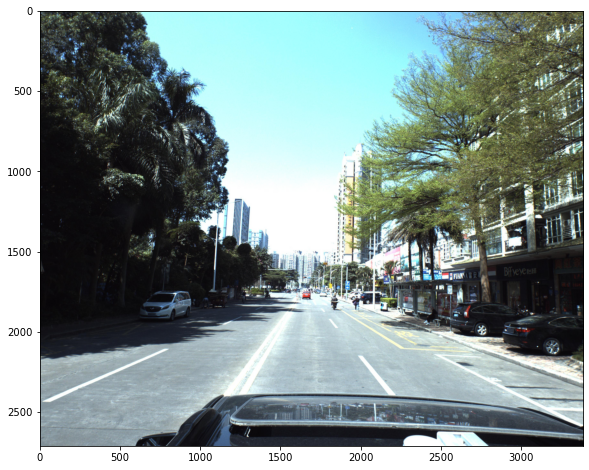

In [24]:
from matplotlib.pyplot import imread
img = imread(PATH + 'train_images/ID_8a6e65317' + '.jpg')
plt.figure(figsize=(15,8))
plt.imshow(img);

In [25]:
def str2coords(s, names=['id', 'yaw', 'pitch', 'roll', 'x', 'y', 'z']):
    '''
    Input:
        s: PredictionString (e.g. from train dataframe)
        names: array of what to extract from the string
    Output:
        list of dicts with keys from `names`
    '''
    coords = []
    for l in np.array(s.split()).reshape([-1, 7]):
        coords.append(dict(zip(names, l.astype('float'))))
        if 'id' in coords[-1]:
            coords[-1]['id'] = int(coords[-1]['id'])
    return coords

In [26]:
inp = train['PredictionString'][0]
print('Example input:\n', inp)
print()
print('Output:\n', str2coords(inp))

Example input:
 16 0.254839 -2.57534 -3.10256 7.96539 3.20066 11.0225 56 0.181647 -1.46947 -3.12159 9.60332 4.66632 19.339 70 0.163072 -1.56865 -3.11754 10.39 11.2219 59.7825 70 0.141942 -3.1395 3.11969 -9.59236 5.13662 24.7337 46 0.163068 -2.08578 -3.11754 9.83335 13.2689 72.9323

Output:
 [{'id': 16, 'yaw': 0.254839, 'pitch': -2.57534, 'roll': -3.10256, 'x': 7.96539, 'y': 3.20066, 'z': 11.0225}, {'id': 56, 'yaw': 0.181647, 'pitch': -1.46947, 'roll': -3.12159, 'x': 9.60332, 'y': 4.66632, 'z': 19.339}, {'id': 70, 'yaw': 0.163072, 'pitch': -1.56865, 'roll': -3.11754, 'x': 10.39, 'y': 11.2219, 'z': 59.7825}, {'id': 70, 'yaw': 0.141942, 'pitch': -3.1395, 'roll': 3.11969, 'x': -9.59236, 'y': 5.13662, 'z': 24.7337}, {'id': 46, 'yaw': 0.163068, 'pitch': -2.08578, 'roll': -3.11754, 'x': 9.83335, 'y': 13.2689, 'z': 72.9323}]


## Data Distributions

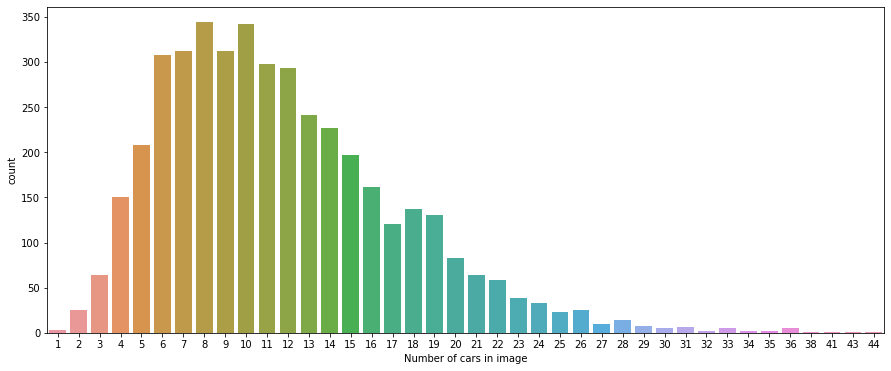

In [27]:
lens = [len(str2coords(s)) for s in train['PredictionString']]

plt.figure(figsize=(15,6))
sns.countplot(lens);
plt.xlabel('Number of cars in image');

## DataFrame of all points

In [28]:
points_df = pd.DataFrame()
for col in ['x', 'y', 'z', 'yaw', 'pitch', 'roll']:
    arr = []
    for ps in train['PredictionString']:
        coords = str2coords(ps)
        arr += [c[col] for c in coords]
    points_df[col] = arr

print('len(points_df)', len(points_df))
points_df.head()

len(points_df) 49684


x         y        z       yaw    pitch     roll
0   7.96539   3.20066  11.0225  0.254839 -2.57534 -3.10256
1   9.60332   4.66632  19.3390  0.181647 -1.46947 -3.12159
2  10.39000  11.22190  59.7825  0.163072 -1.56865 -3.11754
3  -9.59236   5.13662  24.7337  0.141942 -3.13950  3.11969
4   9.83335  13.26890  72.9323  0.163068 -2.08578 -3.11754

## Distribution of target poses

### 1) X

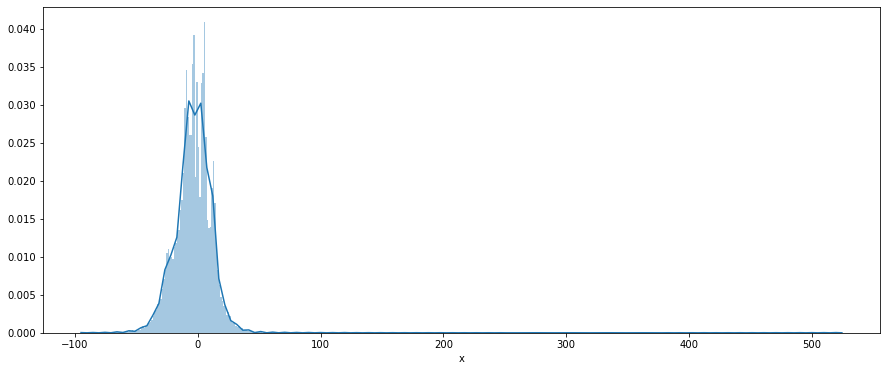

In [29]:
plt.figure(figsize=(15,6))
sns.distplot(points_df['x'], bins=500);
plt.xlabel('x')
plt.show()

### 2) Y

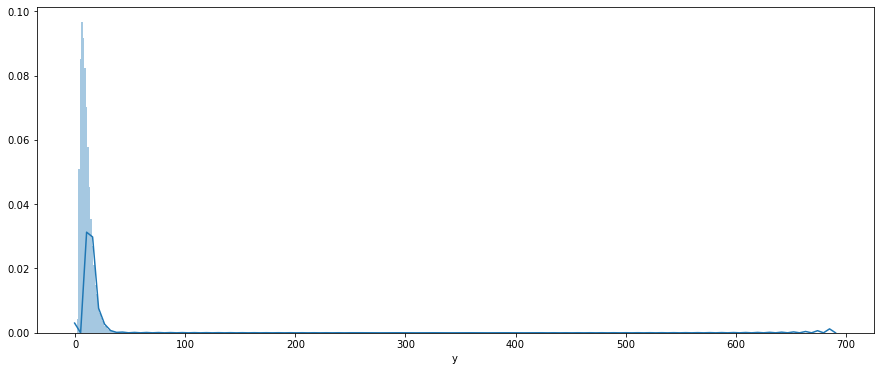

In [30]:
plt.figure(figsize=(15,6))
sns.distplot(points_df['y'], bins=500);
plt.xlabel('y')
plt.show()

### 3) Z

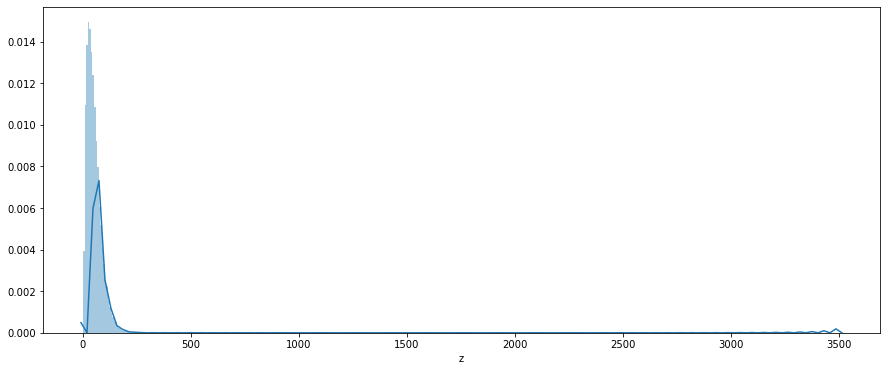

In [31]:
plt.figure(figsize=(15,6))
sns.distplot(points_df['z'], bins=500);
plt.xlabel('z')
plt.show()

### 4) Yaw

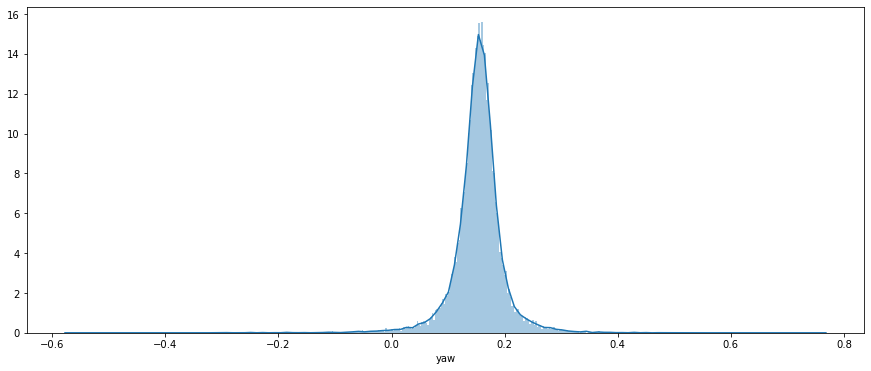

In [32]:
plt.figure(figsize=(15,6))
sns.distplot(points_df['yaw'], bins=500);
plt.xlabel('yaw')
plt.show()

### 5) Pitch

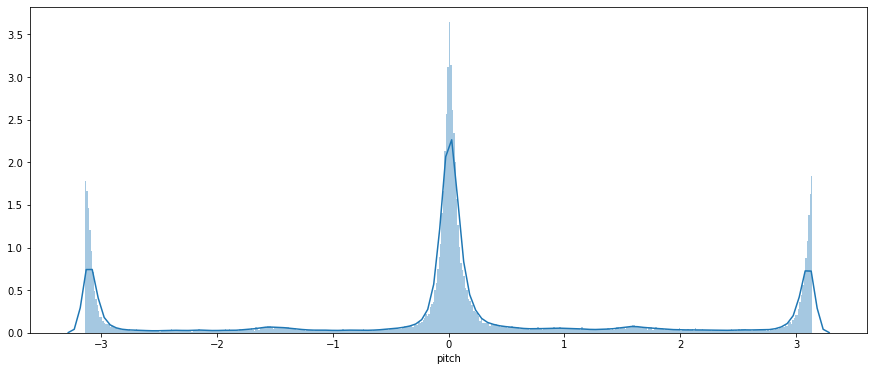

In [33]:
plt.figure(figsize=(15,6))
sns.distplot(points_df['pitch'], bins=500);
plt.xlabel('pitch')
plt.show()

I guess, pitch and yaw are mixed up in this dataset. Pitch cannot be that big. That would mean that cars are upside down.

### 6) Roll

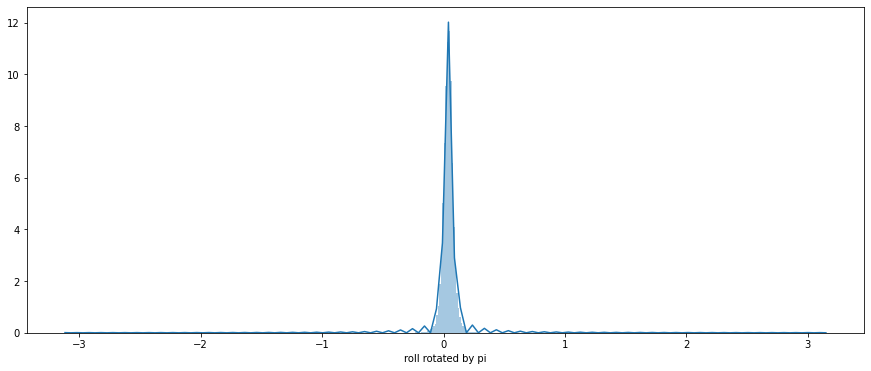

In [34]:
def rotate(x, angle):
    x = x + angle
    x = x - (x + np.pi) // (2 * np.pi) * 2 * np.pi
    return x

plt.figure(figsize=(15,6))
sns.distplot(points_df['roll'].map(lambda x: rotate(x, np.pi)), bins=500);
plt.xlabel('roll rotated by pi')
plt.show()

## 2D Visualization

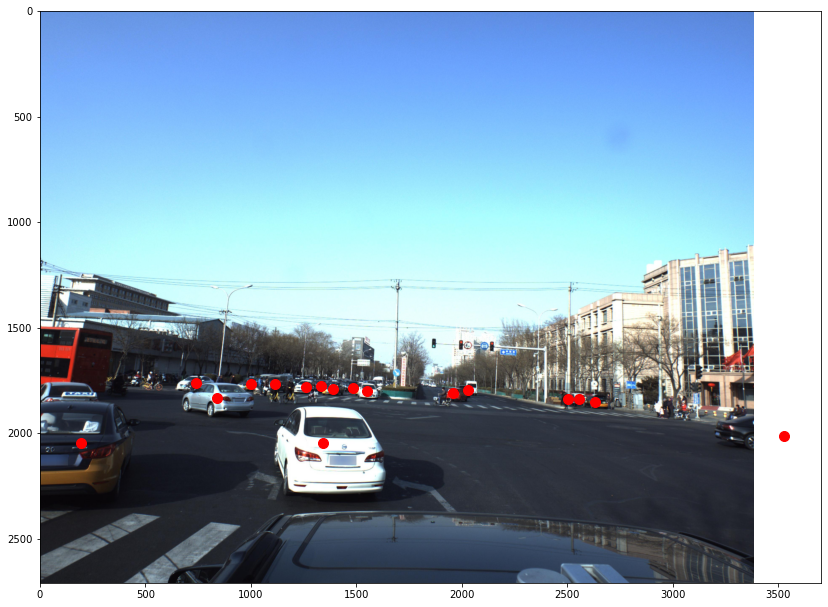

In [35]:
global camera_matrix
def get_img_coords(s):
    '''
    Input is a PredictionString (e.g. from train dataframe)
    Output is two arrays:
        xs: x coordinates in the image (row)
        ys: y coordinates in the image (column)
    '''
    camera_matrix = np.array([[2304.5479, 0,  1686.2379],
                          [0, 2305.8757, 1354.9849],
                          [0, 0, 1]], dtype=np.float32)
    camera_matrix_inv = np.linalg.inv(camera_matrix)
    coords = str2coords(s)
    xs = [c['x'] for c in coords]
    ys = [c['y'] for c in coords]
    zs = [c['z'] for c in coords]
    P = np.array(list(zip(xs, ys, zs))).T
    img_p = np.dot(camera_matrix, P).T
    img_p[:, 0] /= img_p[:, 2]
    img_p[:, 1] /= img_p[:, 2]
    img_xs = img_p[:, 0]
    img_ys = img_p[:, 1]
    img_zs = img_p[:, 2] # z = Distance from the camera
    return img_xs, img_ys

plt.figure(figsize=(14,14))
plt.imshow(imread(PATH + 'train_images/' + train['ImageId'][2217] + '.jpg'))
plt.scatter(*get_img_coords(train['PredictionString'][2217]), color='red', s=100);

Let's look at the distribution of all points.

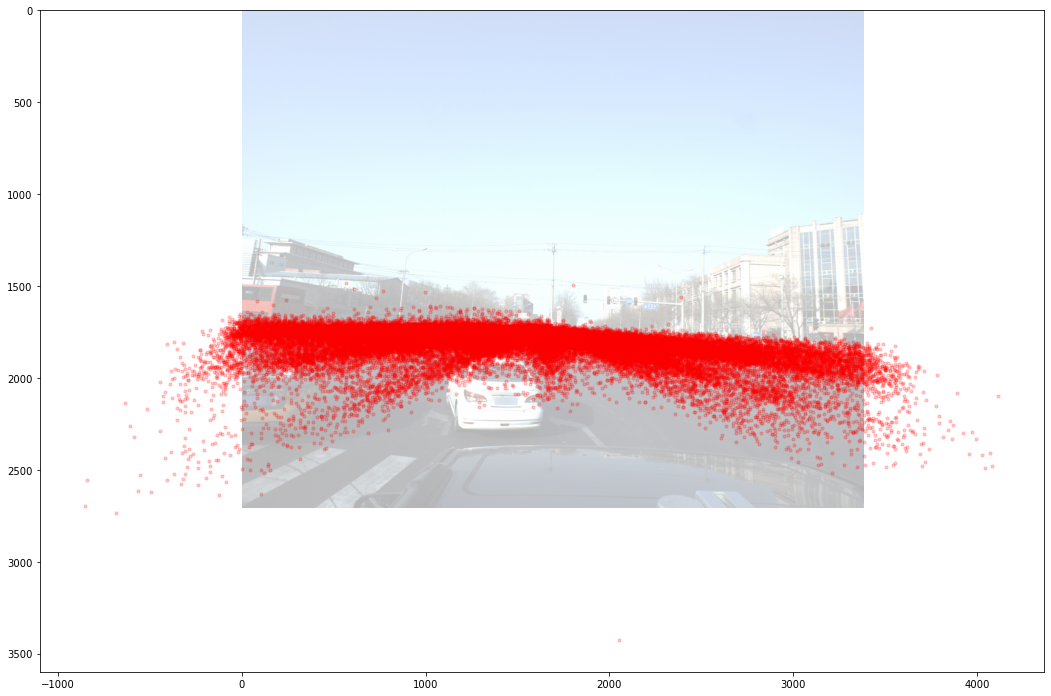

In [36]:
xs, ys = [], []

for ps in train['PredictionString']:
    x, y = get_img_coords(ps)
    xs += list(x)
    ys += list(y)

plt.figure(figsize=(18,18))
plt.imshow(imread(PATH + 'train_images/' + train['ImageId'][2217] + '.jpg'), alpha=0.3)
plt.scatter(xs, ys, color='red', s=10, alpha=0.2);

Many points are outside!

Let's look at this distribution "from the sky"

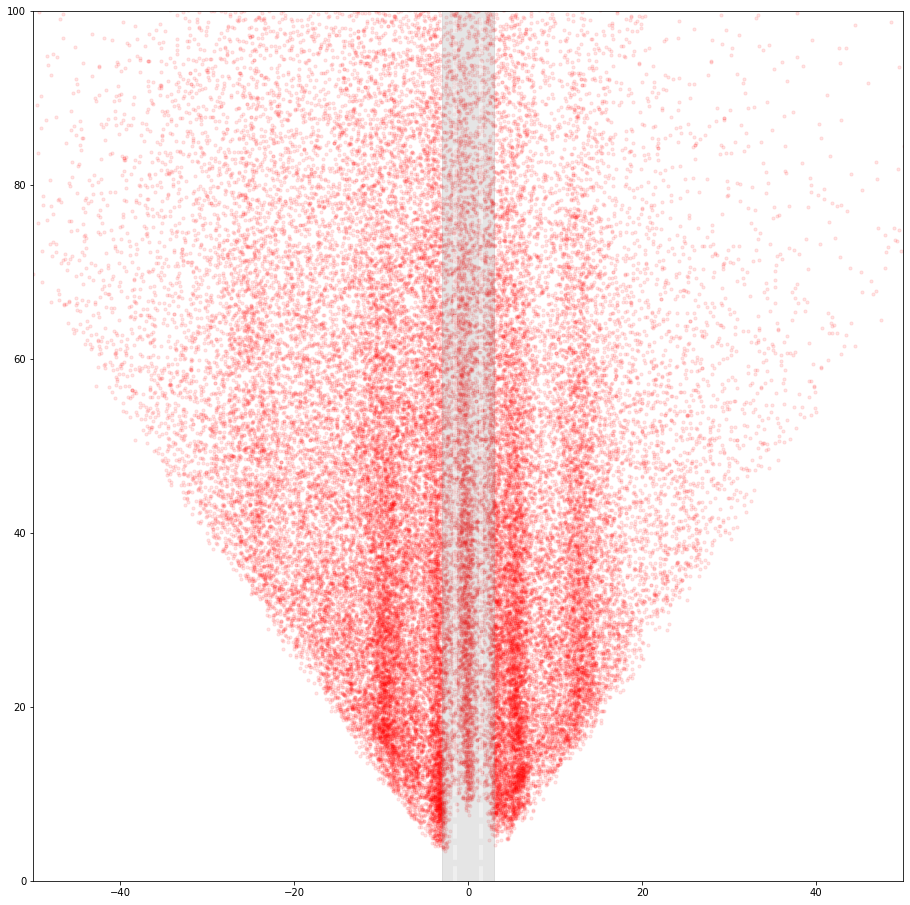

In [37]:
# Road points
road_width = 3
road_xs = [-road_width, road_width, road_width, -road_width, -road_width]
road_ys = [0, 0, 500, 500, 0]

plt.figure(figsize=(16,16))
plt.axes().set_aspect(1)
plt.xlim(-50,50)
plt.ylim(0,100)

# View road
plt.fill(road_xs, road_ys, alpha=0.2, color='gray')
plt.plot([road_width/2,road_width/2], [0,100], alpha=0.4, linewidth=4, color='white', ls='--')
plt.plot([-road_width/2,-road_width/2], [0,100], alpha=0.4, linewidth=4, color='white', ls='--')
# View cars
plt.scatter(points_df['x'], np.sqrt(points_df['z']**2 + points_df['y']**2), color='red', s=10, alpha=0.1);

## 3D Distribution of Points

In [38]:
fig = px.scatter_3d(points_df, x='x', y='y', z='z',color='pitch', range_x=(-50,50), range_y=(0,50), range_z=(0,250), opacity=0.1)
fig.show()

1) x is measured from left to right

2) I thought that y is the distance from the car and z is height above the road. Looks like this is not the case.

Let's look how good these points lay in one plane
Try to predict y knowing x, z:

In [39]:
zy_slope = LinearRegression()
X = points_df[['z']]
y = points_df['y']
zy_slope.fit(X, y)
print('MAE without x:', mean_absolute_error(y, zy_slope.predict(X)))

# Will use this model later
xzy_slope = LinearRegression()
X = points_df[['x', 'z']]
y = points_df['y']
xzy_slope.fit(X, y)
print('MAE with x:', mean_absolute_error(y, xzy_slope.predict(X)))

print('\ndy/dx = {:.3f}\ndy/dz = {:.3f}'.format(*xzy_slope.coef_))

MAE without x: 0.655378235298673
MAE with x: 0.44816612890041035

dy/dx = 0.051
dy/dz = 0.169


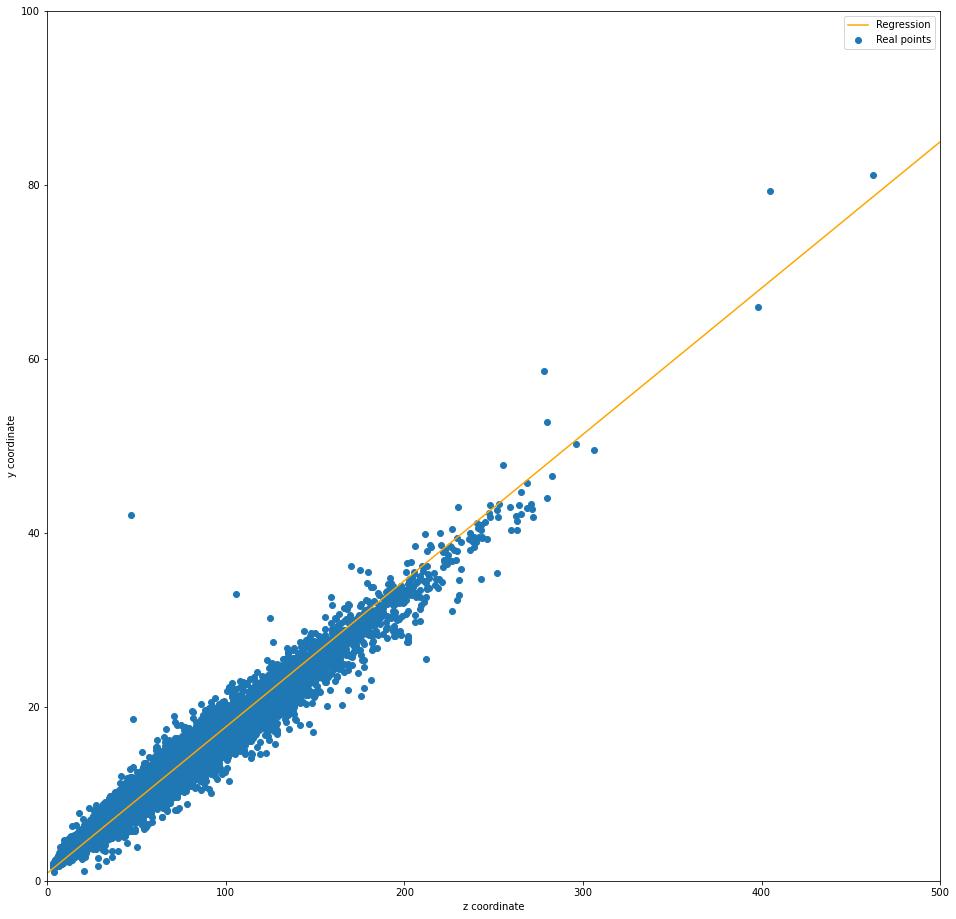

In [40]:
plt.figure(figsize=(16,16))
plt.xlim(0,500)
plt.ylim(0,100)
plt.scatter(points_df['z'], points_df['y'], label='Real points')
X_line = np.linspace(0,500, 10)
plt.plot(X_line, zy_slope.predict(X_line.reshape(-1, 1)), color='orange', label='Regression')
plt.legend()
plt.xlabel('z coordinate')
plt.ylabel('y coordinate');